# 학습 완료된 LoRA 모델을 원래 모델로 Merge


In [16]:
!pip install -q torch==2.1.0 transformers>=4.25.1 accelerate>=0.22.0 peft==0.7.0 diffusers>=0.27.2 xformers --extra-index-url=https://download.pytorch.org/whl/cu118

In [1]:
from diffusers import DiffusionPipeline, AutoencoderKL, LCMScheduler
from diffusers.utils import load_image, make_image_grid
import torch

In [2]:
cache_dir = "/home/ec2-user/SageMaker/.cache"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 모델 다운로드


In [3]:
s3_model_artifact = "s3://sagemaker-us-east-1-851725450449/sdxl-txt2img-lora/output/sdxl-txt2img-lora-2024-03-04-14-26-34-195/output/model.tar.gz"

In [4]:
!mkdir -p models
!aws s3 cp $s3_model_artifact models/

download: s3://sagemaker-us-east-1-851725450449/sdxl-txt2img-lora/output/sdxl-txt2img-lora-2024-03-04-14-26-34-195/output/model.tar.gz to models/model.tar.gz


In [5]:
!tar zxvf models/model.tar.gz -C models/

tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'
pytorch_lora_weights.safetensors


# 모델 테스트


In [6]:
model_id = "stabilityai/stable-diffusion-xl-base-1.0"
vae_id = "madebyollin/sdxl-vae-fp16-fix"

In [7]:
vae = AutoencoderKL.from_pretrained(vae_id, torch_dtype=torch.float16)

pipe = DiffusionPipeline.from_pretrained(
    model_id,
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
    cache_dir=cache_dir,
)
pipe.enable_xformers_memory_efficient_attention()

pipe.load_lora_weights(
    "./models",
    adapter_name="lora",
    cache_dir=cache_dir,
)

pipe.set_adapters(["lora"], adapter_weights=[1.0])
pipe.to(device=device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionXLPipeline {
  "_class_name": "StableDiffusionXLPipeline",
  "_diffusers_version": "0.26.3",
  "_name_or_path": "stabilityai/stable-diffusion-xl-base-1.0",
  "feature_extractor": [
    null,
    null
  ],
  "force_zeros_for_empty_prompt": true,
  "image_encoder": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "EulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

  0%|          | 0/30 [00:00<?, ?it/s]

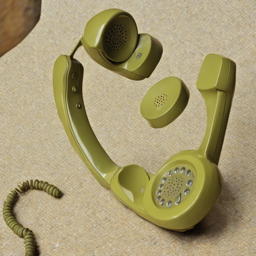

In [8]:
img = pipe(
    prompt='a telephone handset',
    negative_prompt='cord, hand, watermark',
    num_inference_steps=50,
    guidance_scale=7.5,
).images[0]
img.resize((256, 256))

# 모델 머지 (fuse)


In [9]:
pipe.fuse_lora(lora_scale=1.0)
pipe.unload_lora_weights()
pipe.save_pretrained('./fused')